<a href="https://colab.research.google.com/github/toledojm/josetoledo_datathon/blob/main/josetoledo_datathon_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATATHON JOSE TOLEDO DATA-03
## Predicción de envios a tiempo de una empresa de logística de E-commerce



se importan los modulos con las librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from sklearn.pipeline import Pipeline

from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

se importan los datasets desde el repo de github

In [60]:
ECommerce_test_url = 'https://github.com/toledojm/Datathon/blob/main/E-Commerce_test.xlsx?raw=true'
ECommerce_train_url ='https://github.com/toledojm/Datathon/blob/main/E-Commerce_train.xlsx?raw=true'

In [61]:
df_evaluador= pd.read_excel(ECommerce_train_url)
df_predictor= pd.read_excel(ECommerce_test_url)

## Descripción de las dimensiones

- ID: identificador del registro de orden (valor entero).
- Warehouse_block: Almacén de distribución de donde salió la orden (A a F).
- Mode_of_Shipment: Medio de transporte (Flight, Road, Ship).
- Customer_care_calls: Número de llamadas a atención al cliente que hubo por esa orden. (valores enteros del 2 al 7)
- Customer_rating: Puntaje del cliente (valores enteros 1 al 5).
- Cost_of_the_Product: Costo del producto (valor numérico entero de 96 a 310).
- Prior_purchases: Número de compras previas realizadas por el cliente (valor numérico entero de 2 a 10).
- Product_importance: Nivel de importancia del producto (low, medium, high).
- Gender: Género del comprador (F, M).
-Discount_offered: Porcentaje de descuento ofrecido por esa compra (valor numérico entero de 1 a 65):
- Weight_in_gms: Peso del paquete de la orden, en gramos (valor numérico entero de 1001 a 7846).
- Reached.on.Time_Y.N: Información sobre la llegada del paquete a destino (1 si llegó a tiempo, 0 si no llegó a tiempo).


# COMIENZO DEL EDA

descripción archivo: 'E-Commerce_test.xlsx', 2000 observaciones y 11 dimensiones, sin incluir información sobre si el envío llegó a tiempo o no en el momento del registro.

In [62]:
df_evaluador.info() # chequeo el tipo de dato según la descripción de dimensiones

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999 entries, 0 to 8998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   8999 non-null   int64 
 1   Warehouse_block      8999 non-null   object
 2   Mode_of_Shipment     8999 non-null   object
 3   Customer_care_calls  8999 non-null   int64 
 4   Customer_rating      8999 non-null   int64 
 5   Cost_of_the_Product  8999 non-null   int64 
 6   Prior_purchases      8999 non-null   int64 
 7   Product_importance   8999 non-null   object
 8   Gender               8999 non-null   object
 9   Discount_offered     8999 non-null   int64 
 10  Weight_in_gms        8999 non-null   int64 
 11  Reached.on.Time_Y.N  8999 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 843.8+ KB


no se obseraban valores faltantes ni nulos para el archivo para entrenamiento de los modelos

descripción archivo: 'E-Commerce_train.xlsx', 8999 observaciones y 12 dimensiones, incluyendo información sobre si el envío llegó a tiempo o no en el momento del registro.

In [63]:
df_predictor.info() # chequeo el tipo de dato según la descripción de dimensiones

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2000 non-null   int64 
 1   Warehouse_block      2000 non-null   object
 2   Mode_of_Shipment     2000 non-null   object
 3   Customer_care_calls  2000 non-null   int64 
 4   Customer_rating      2000 non-null   int64 
 5   Cost_of_the_Product  2000 non-null   int64 
 6   Prior_purchases      2000 non-null   int64 
 7   Product_importance   2000 non-null   object
 8   Gender               2000 non-null   object
 9   Discount_offered     2000 non-null   int64 
 10  Weight_in_gms        2000 non-null   int64 
dtypes: int64(7), object(4)
memory usage: 172.0+ KB


no se obseraban valores faltantes ni nulos en el archivo para p¡la predicción final

In [78]:
df_predictor.drop(['ID'], axis=1,inplace=True)
df_evaluador.drop(['ID'], axis=1,inplace=True)

In [79]:
print('La cantidad de registros duplicados es:', df_evaluador.duplicated().sum()) # reviso observaciones duplicadas
print('La cantidad de registros duplicados es:', df_predictor.duplicated().sum()) # reviso observaciones duplicadas

La cantidad de registros duplicados es: 0
La cantidad de registros duplicados es: 0


no se observan valores duplicados

In [80]:
print('cantidad de envios a tiempo',df_evaluador["Reached.on.Time_Y.N"].sum())
print('porcentaje de envios a tiempo',round(df_evaluador["Reached.on.Time_Y.N"].sum()/df_evaluador["Reached.on.Time_Y.N"].count()*100,2),'%')

cantidad de envios a tiempo 5719
porcentaje de envios a tiempo 63.55 %


 la variable a predecir esta desbalanceada

In [119]:
# divido los datos aleatoreamente en dos subsets 70% en df_train para entrenar el modelo
# y 30% en df_test para testeo final

array_train, array_test = train_test_split(df_evaluador, test_size = 0.30, random_state = 42)

df_train=pd.DataFrame(array_train)
df_test=pd.DataFrame(array_test)

se evalua los procetajes de desbanalce

In [82]:
print('cantidad de envios a tiempo para el set de entrenamiento',df_train["Reached.on.Time_Y.N"].sum())
print('porcentaje de envios a tiempo para el set de entrenamiento',round(df_train["Reached.on.Time_Y.N"].sum()/df_train["Reached.on.Time_Y.N"].count()*100,2),'%')

print('cantidad de envios a tiempo para el set de evaluación',df_test["Reached.on.Time_Y.N"].sum())
print('porcentaje de envios a tiempo para el set de evaluación',round(df_test["Reached.on.Time_Y.N"].sum()/df_test["Reached.on.Time_Y.N"].count()*100,2),'%')


cantidad de envios a tiempo para el set de entrenamiento 3963
porcentaje de envios a tiempo para el set de entrenamiento 62.91 %
cantidad de envios a tiempo para el set de evaluación 1756
porcentaje de envios a tiempo para el set de evaluación 65.04 %


se crea un dataset balanceado para aplicar los modelos

In [120]:
mask = df_train["Reached.on.Time_Y.N"] == 0
mask.sum()
df_train[~mask].sample(n = 4)
df_subsample_train = pd.concat([df_train[mask], df_train[~mask].sample(n = mask.sum())])
df_subsample_train = df_subsample_train.sample(frac=1,  random_state=42).reset_index(drop=True)

In [155]:
mask = df_test["Reached.on.Time_Y.N"] == 0
mask.sum()
df_test[~mask].sample(n = 4)
df_subsample_test = pd.concat([df_test[mask], df_test[~mask].sample(n = mask.sum())])
df_subsample_test = df_subsample_test.sample(frac=1,  random_state=42).reset_index(drop=True)

In [85]:
print('cantidad de envios a tiempo para el set de evaluación',df_subsample_test["Reached.on.Time_Y.N"].sum())
print('porcentaje de envios a tiempo para el set de evaluación',round(df_subsample_test["Reached.on.Time_Y.N"].sum()/df_subsample_test["Reached.on.Time_Y.N"].count()*100,2),'%')


cantidad de envios a tiempo para el set de evaluación 944
porcentaje de envios a tiempo para el set de evaluación 50.0 %


In [86]:
print('cantidad de envios a tiempo para el set de evaluación',df_subsample_train["Reached.on.Time_Y.N"].sum())
print('porcentaje de envios a tiempo para el set de evaluación',round(df_subsample_train["Reached.on.Time_Y.N"].sum()/df_subsample_train["Reached.on.Time_Y.N"].count()*100,2),'%')


cantidad de envios a tiempo para el set de evaluación 2336
porcentaje de envios a tiempo para el set de evaluación 50.0 %


creo los datasets:
- data=variables que van  apredecir el target
- taget=variable a predecir. envios que llegan a tiempo valor=1 o no valor=0.

In [122]:
#creo los datasets de entrenamiento
data_train=df_subsample_train.drop(["Reached.on.Time_Y.N"], axis=1) # a la vista las variables ID y Gender no me aportan información importante
target_train=df_subsample_train["Reached.on.Time_Y.N"]


In [156]:
#creo los datasets de evaluación
data_test=df_test.drop(["Reached.on.Time_Y.N"], axis=1) # a la vista las variables ID y Gender no me aportan información importante
target_test=df_test["Reached.on.Time_Y.N"]

se listan las variables categóricas y las numéricas para su tratamento específico

In [157]:
num_col_selector = selector(dtype_exclude=object) # selector de variables numéricas
cat_col_selector = selector(dtype_include=object) # selector de variables categóricas

num_col = num_col_selector(df_predictor) # lista de variables numéricas
cat_col = cat_col_selector(df_predictor) # lista de variables categóricas

se crea el preprosesamiento de los datos según su categoría

In [158]:
numeric_transformer = Pipeline([('scaler', MinMaxScaler())]) # Transformaciones para las variables numéricas

categorical_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]) # Transformaciones para las variables categóricas

preprocessor= ColumnTransformer(transformers=[('numeric', numeric_transformer, num_col),
                                              ('categoric', categorical_transformer, cat_col)])



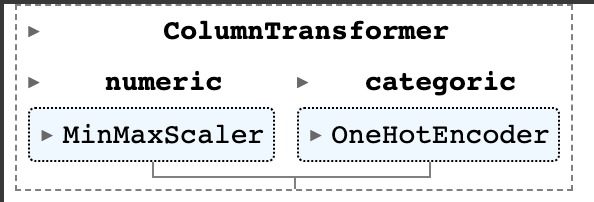

se convierten los dataframes añadiendo las columnas categoricas con el encoder de sus respectivos nombres y  se escalan las numericas


In [159]:
preprocessor.fit(data_train)
encoded_cat = preprocessor.named_transformers_['categoric']['onehot']\
              .get_feature_names_out(cat_col)
labels = np.concatenate([num_col, encoded_cat])
data_train_prep = preprocessor.transform(data_train)
data_train_prep = pd.DataFrame(data_train_prep, columns=labels)

In [160]:
preprocessor.fit(data_test)
encoded_cat = preprocessor.named_transformers_['categoric']['onehot']\
              .get_feature_names_out(cat_col)
labels = np.concatenate([num_col, encoded_cat])
data_test_prep = preprocessor.transform(data_test)
data_test_prep = pd.DataFrame(data_test_prep, columns=labels)

In [161]:
preprocessor.fit(df_predictor)
encoded_cat = preprocessor.named_transformers_['categoric']['onehot']\
              .get_feature_names_out(cat_col)
labels = np.concatenate([num_col, encoded_cat])
data_predictor_prep = preprocessor.transform(df_predictor)
data_predictor_prep = pd.DataFrame(data_predictor_prep, columns=labels)

In [129]:
categorical_reduction=Pipeline([('pca', PCA(n_components=6))])
preprocessor_reduccion= ColumnTransformer(transformers=[('categoric', categorical_reduction, encoded_cat)])

se visualiza mendiante la matriz de correlación las variables que genenar ruido o se encuentran relacionadas con otras

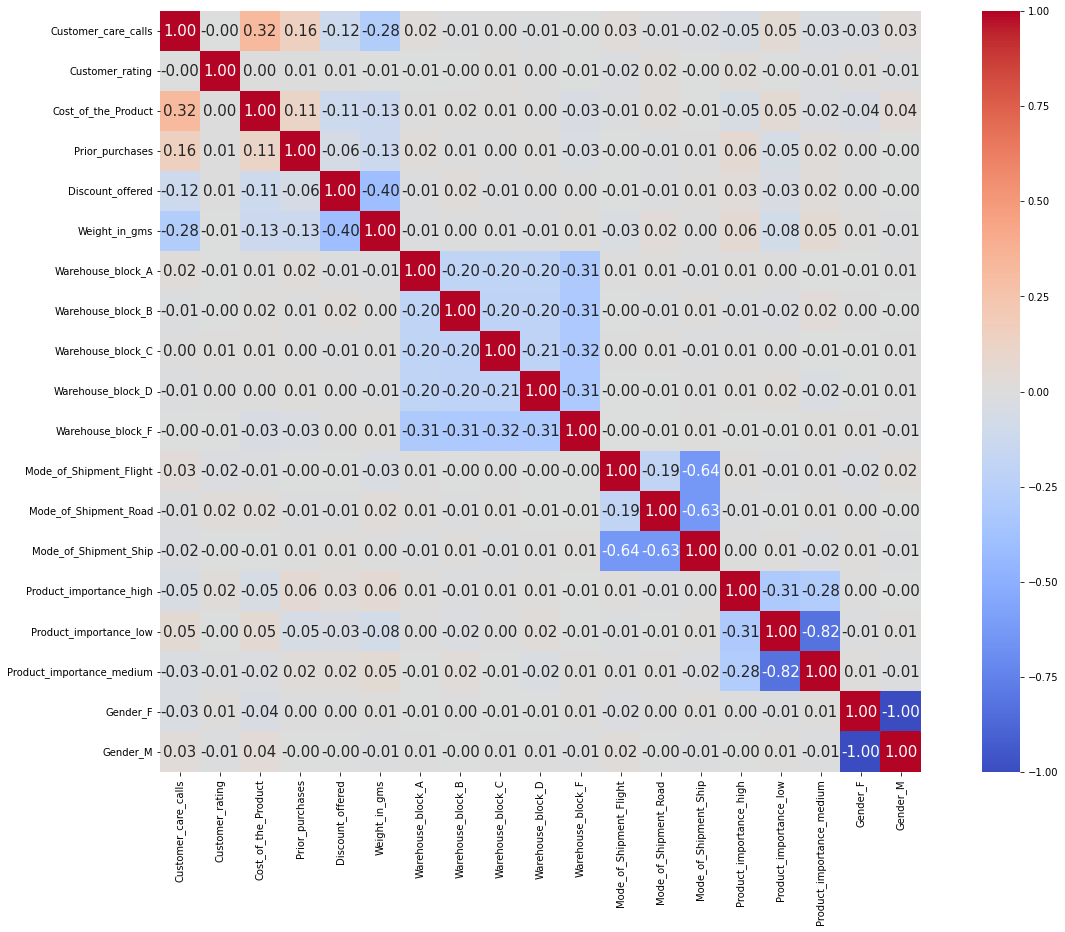

In [130]:
corr = data_train_prep.corr(method='pearson')
plt.figure(figsize=(22,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= data_train_prep.columns, 
           yticklabels= data_train_prep.columns,
           cmap= 'coolwarm')
plt.show()

se elimina las variables correlacionadas o con ruido

se crean los sets de entrenamiento y testeo

In [162]:
data_train_prep.drop(['Product_importance_medium','Gender_F','Gender_M'], axis=1, inplace=True)
data_test_prep.drop(['Product_importance_medium','Gender_F','Gender_M'], axis=1, inplace=True)
data_predictor_prep.drop(['Product_importance_medium','Gender_F','Gender_M'], axis=1, inplace=True)

In [163]:
x_train, x_test, y_train, y_test = train_test_split(data_train_prep,target_train,test_size = 0.3, random_state=42, stratify=target_train)

## finaliza el EDA y comienza la busqueda del modelo predictor

In [164]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import sklearn.metrics as metrics

In [138]:
model_xgb = xgb.XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',silent=True, nthread=1)
params_xgb = {
        'min_child_weight': [1, 5, 10],
        'gamma': [ 1, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]}

gs_xgb = GridSearchCV(model_xgb ,
                      param_grid=params_xgb,
                      scoring='accuracy',
                      cv=3,n_jobs=-1)
gs_xgb.fit(x_train, y_train)
gs_xgb.best_params_

{'colsample_bytree': 0.6,
 'gamma': 1,
 'max_depth': 3,
 'min_child_weight': 5,
 'subsample': 0.6}

In [165]:
clf_xgb = xgb.XGBClassifier(colsample_bytree= 0.6,
                            gamma=1,max_depth=3,
                            min_child_weight= 5,
                            subsample=0.6,
                            learning_rate=0.02, 
                            n_estimators=100, 
                            objective='binary:logistic',
                            silent=True, nthread=1)
                            
# Entrenamos
clf_xgb.fit(x_train, y_train)
# Predecimos

y_train_pred = clf_xgb.predict(x_train)
y_test_pred = clf_xgb.predict(x_test)

print(classification_report(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       0.69      0.98      0.81      1635
           1       0.97      0.57      0.72      1635

    accuracy                           0.78      3270
   macro avg       0.83      0.78      0.77      3270
weighted avg       0.83      0.78      0.77      3270



In [166]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.69      0.98      0.81       701
           1       0.97      0.55      0.71       701

    accuracy                           0.77      1402
   macro avg       0.83      0.77      0.76      1402
weighted avg       0.83      0.77      0.76      1402



In [168]:
print(confusion_matrix(y_train, y_train_pred))

print(confusion_matrix(y_test, y_test_pred))

[[1609   26]
 [ 708  927]]
[[690  11]
 [313 388]]


In [169]:
clf_xgb.fit(data_test_prep, target_test)

target_test_pred = clf_xgb.predict(data_test_prep)

print(classification_report(target_test, target_test_pred))

              precision    recall  f1-score   support

           0       0.60      0.71      0.65       944
           1       0.83      0.75      0.79      1756

    accuracy                           0.73      2700
   macro avg       0.72      0.73      0.72      2700
weighted avg       0.75      0.73      0.74      2700



In [170]:
print(confusion_matrix(target_test, target_test_pred))

[[ 673  271]
 [ 445 1311]]


In [171]:
prediction = pd.DataFrame(clf_xgb.predict(data_predictor_prep), columns=['pred'])
prediction.value_counts()

pred
1       1939
0         61
dtype: int64

In [172]:
print('cantidad de envios a tiempo',prediction.pred.sum())
print('porcentaje de envios a tiempo',round(prediction.pred.sum()/prediction.pred.count()*100,2),'%')

cantidad de envios a tiempo 1939
porcentaje de envios a tiempo 96.95 %


In [173]:
prediction.to_csv('toledojm3.csv',index=False)
!cp toledojm3.csv "/content/drive/MyDrive/Datathon"

# FIN